_Version log: Optimisation using Principle Component Analysis._

In [1]:
import sys, warnings, os
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft, linalg as spla
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [28]:
import os
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as spla
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

In [29]:
training_dataset = 2

training_directory = "data\\training_set{0:}\\".format(training_dataset)
training_file_paths = [os.path.join(training_directory, file_name) for file_name in os.listdir(training_directory)]

training_data = np.array([np.genfromtxt(file_path, delimiter=",", filling_values= np.nan) for file_path in training_file_paths])

training_data = np.rollaxis(training_data, -1, 0) # move the last axis to the front
training_interferograms, training_uncertainty = training_data # now we can seperate the interferograms from the uncertainties. :)

training_interferograms.shape

(900, 200)

In [30]:
interferogram_to_test = 12

test_file_name = "1dmockanderrors{0:d}".format(interferogram_to_test)

test_interferogram, test_uncertainties = cs.open_dataset(test_file_name, ".csv")

In [31]:
number_of_pca_components = 200 # use `None` for all of them.

pca = PCA(n_components= number_of_pca_components)
pca.fit(training_interferograms) # is it possible to weight the datapoints using the uncertainty?

relitive_importance = pca.explained_variance_ratio_ #The most important component is first.
basis_transform = pca.components_ # components in the original basis.

sparse_interferograms = pca.transform(training_interferograms) #transform the interferograms into the sparse basis
test_in_new_basis = pca.transform(test_interferogram[None, :])

# Reconstruct original data
recovered_interferogram = pca.inverse_transform(test_in_new_basis)[0]
recovered_interferogram2 = np.matmul(test_in_new_basis, basis_transform)[0] + pca.mean_ # like lasso, pca also normalises the data so the mean is more difficult to recover.

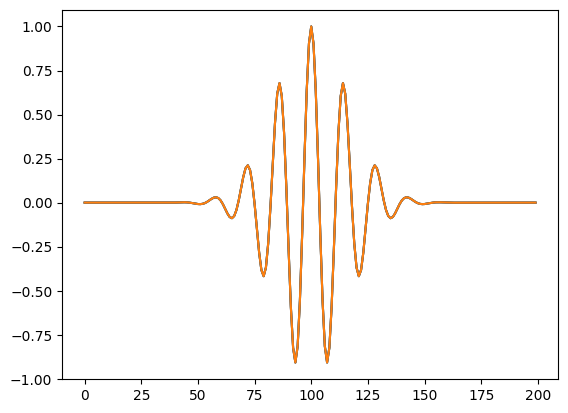

In [32]:
plt.plot(test_interferogram, color= "k")

plt.plot(recovered_interferogram)
plt.plot(recovered_interferogram2) #Should be the same

plt.show()

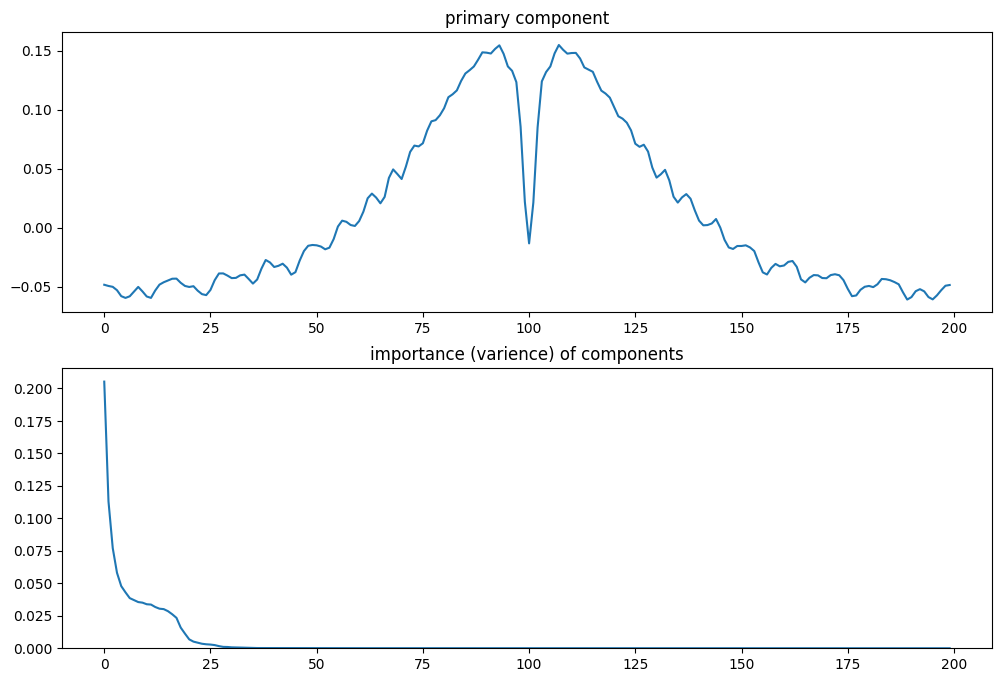

In [33]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(basis_transform[0])
axs[0].set(title= "primary component")

axs[1].plot(relitive_importance)
axs[1].set(ylim= (0, None), title= "importance (varience) of components")

plt.show()

In [34]:
# Compute QR factorization with column pivoting
Q, R, permutation_matrix = spla.qr(basis_transform, pivoting= True)

# P is the permutation matrix
print("Permutation Matrix (P):")
print(permutation_matrix)


Permutation Matrix (P):
[ 11  15  85 126  24  27  44  66  95 176  25   5  69  71 157 160 177 129
 154  50 100 131 156 185  40 146 189  35  58  84 165  65  78 171 188 114
  14 197 119 151  52  81 103 124 104   3  34   8  51  31 130 148  99 132
 134 170 198 180 190 147 155  16   7  12 139 191  90   4 136  97  28  42
   1 169 184 186 193 195 196  63  67 108  38 145 153  72 164 166 181  75
 187  91  93   0 123 142  10  48  60  55  33 174  74  32 199 113  94 128
  17  21 135  68  98 167 168  76  77  37  45  47 144  96 112 173   9  88
 115 116  13  53 111 149  18 159  86  30  92 101  61 125 183  46  26  70
 192  83  41  54 110  87  73 106  57  64 182 102 143 118  56   6 161  59
  80 175  43 138 178 179 122  22  36 194 127 107 137 163  79 152  19  62
 141  82 172 158  29 121 105   2 109 150  39 117 140  49  20  89 133 120
  23 162]


In [35]:
number_of_detectors = 8
regularization_coeffient = 1e-4

detectors = permutation_matrix[:number_of_detectors]

print(*np.sort(detectors), sep= ",")

11,15,24,27,44,66,85,126


In [36]:
samples = test_interferogram[detectors]
measurement_matrix = basis_transform[:,detectors]
mean = np.mean(samples)

lasso = Lasso(alpha= regularization_coeffient)
lasso.fit(measurement_matrix.T, samples)

result = np.matmul(basis_transform.T, lasso.coef_) +mean

In [37]:
result2 = cs.compressed_sensing(samples, detectors, 200, regularization_coeffient)

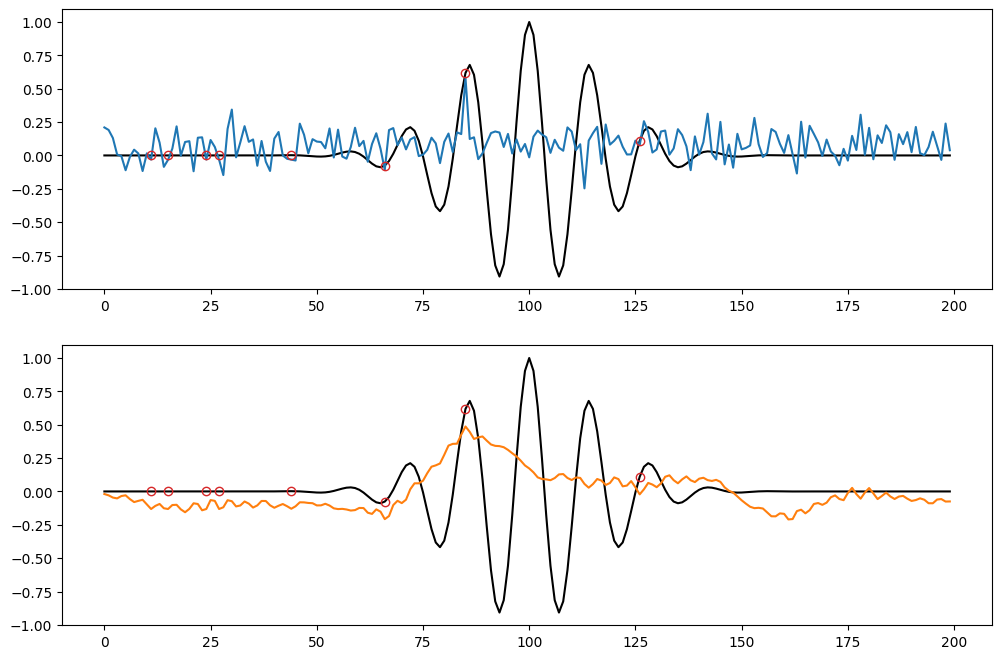

In [38]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(test_interferogram, color= "k")
axs[0].plot(result, color= "tab:blue")
axs[0].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

axs[1].plot(test_interferogram, color= "k")
axs[1].plot(result2, color= "tab:orange")
axs[1].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

plt.show()